In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [2]:
print("GPU Available:", tf.test.is_gpu_available())
print("TensorFlow Version:", tf.__version__)
print("GPU Device Name:", tf.config.experimental.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: False
TensorFlow Version: 2.13.0
GPU Device Name: []


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

print("Now using:", tf.config.list_physical_devices('GPU'))

Now using: []


In [4]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [5]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [6]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [7]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [8]:
BATCH_SIZE = 32

EPOCHS = 30

In [9]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = '../PigData_PP/training'

# path to VALIDATE dataset of the OCT images
VALID_PATH = '../PigData_PP/val'

# path to TESTING dataset of the OCT images
TEST_PATH = '../PigData_PP/test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [10]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-20]:
    layer.trainable = False

In [11]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [12]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.2)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [13]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [14]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [16]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 2590 images belonging to 5 classes.


In [17]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [18]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 740 images belonging to 5 classes.


In [19]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 370 images belonging to 5 classes.


In [20]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

#time taken: 3 hours

Epoch 1/30
81/81 [==============================] - 119s 1s/step - loss: 1.5918 - accuracy: 0.4417 - val_loss: 1.1124 - val_accuracy: 0.5676
Epoch 2/30
81/81 [==============================] - 109s 1s/step - loss: 1.0937 - accuracy: 0.5965 - val_loss: 0.9967 - val_accuracy: 0.6203
Epoch 3/30
81/81 [==============================] - 113s 1s/step - loss: 0.9602 - accuracy: 0.6517 - val_loss: 0.7285 - val_accuracy: 0.7041
Epoch 4/30
81/81 [==============================] - 112s 1s/step - loss: 0.7869 - accuracy: 0.7120 - val_loss: 0.7421 - val_accuracy: 0.7203
Epoch 5/30
81/81 [==============================] - 109s 1s/step - loss: 0.7657 - accuracy: 0.7263 - val_loss: 0.6851 - val_accuracy: 0.7500
Epoch 6/30
81/81 [==============================] - 113s 1s/step - loss: 0.7302 - accuracy: 0.7371 - val_loss: 0.5817 - val_accuracy: 0.7932
Epoch 7/30
81/81 [==============================] - 118s 1s/step - loss: 0.6708 - accuracy: 0.7556 - val_loss: 0.5557 - val_accuracy: 0.7919
Epoch 8/30
81

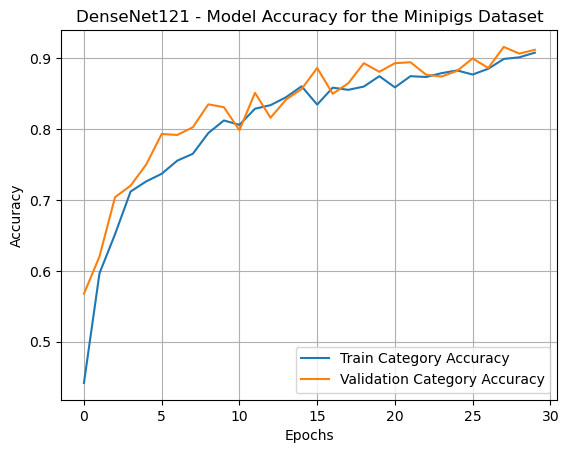

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

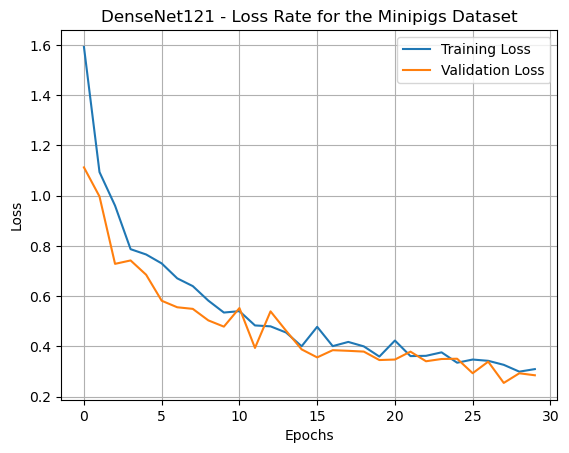

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [23]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 18s 1s/step - loss: 0.3193 - accuracy: 0.8984

Learn Rate = 0.0001 , Epochs = 30 , Training Folder = ../PigData_PP/training
Validation Folder = ../PigData_PP/val , Test Folder = ../PigData_PP/test

Training: 0.932, Validation: 0.898

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [24]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

12/16 [=====================>........] - ETA: 4s - loss: 0.3957 - accuracy: 0.8703WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 16 batches). You may need to use the repeat() function when building your dataset.


16/16 [==============================] - 14s 792ms/step - loss: 0.3957 - accuracy: 0.8703

Test loss and accuracy are: [0.39568662643432617, 0.8702702522277832]


In [25]:
model.save('model_0.1dropout_-20layers_20epochs_202503005.h5')

/Users/owner/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
#!pip install scikit-learn
#!pip install seaborn

In [27]:
cnn_predictions = model.predict(test_set)
print('\nPredictions:\n')
print(cnn_predictions)

cnn_predictions_max = cnn_predictions.argmax(axis=1)
print('\nPredictions argmax(axis=1):\n')
print(cnn_predictions_max)

print(test_set.labels)

print('\nTesting execution ended.\n')


12/12 [==============================] - 14s 1s/step

Predictions:

[[0.0000e+00 0.0000e+00 3.5763e-07 1.0000e+00 3.0398e-06]
 [4.8876e-05 5.9605e-08 1.9867e-02 9.7998e-01 1.9073e-06]
 [1.3054e-02 6.1393e-05 4.5654e-01 5.2979e-01 4.7684e-07]
 ...
 [0.0000e+00 2.3842e-07 3.7289e-04 1.0000e+00 1.6212e-05]
 [5.9605e-08 5.4407e-04 2.9770e-02 9.6875e-01 6.7711e-04]
 [1.0000e+00 2.8610e-06 1.5008e-04 5.9605e-08 0.0000e+00]]

Predictions argmax(axis=1):

[3 3 3 2 0 1 0 3 3 1 4 1 1 3 1 0 3 0 2 1 1 3 3 4 1 3 4 2 2 0 0 3 4 2 2 1 2
 3 0 3 0 4 0 0 1 1 3 0 3 1 0 4 1 0 2 1 0 1 0 4 3 0 1 0 3 2 3 0 2 1 1 2 2 4
 4 2 2 2 1 2 0 3 3 0 2 4 1 3 2 1 1 3 1 1 0 3 0 0 1 1 2 2 2 4 1 2 1 2 1 1 0
 0 4 2 0 2 3 4 0 4 1 1 0 4 1 3 1 1 3 0 1 1 0 2 3 4 3 0 1 0 3 0 0 3 0 1 0 3
 4 0 2 3 4 2 3 4 1 1 3 0 2 0 0 4 3 1 3 1 1 2 2 0 3 4 4 4 4 4 4 2 3 1 2 3 3
 1 0 0 1 3 0 2 3 1 0 1 1 4 3 3 0 3 0 3 1 2 1 3 4 3 0 0 4 2 3 0 1 2 1 4 2 0
 1 4 0 1 0 3 4 4 3 0 1 2 4 0 3 3 1 3 3 1 4 3 1 4 4 1 1 1 4 2 3 3 4 3 3 1 2
 4 4 1 1 0 1 3 4 4 2 0 

In [28]:

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

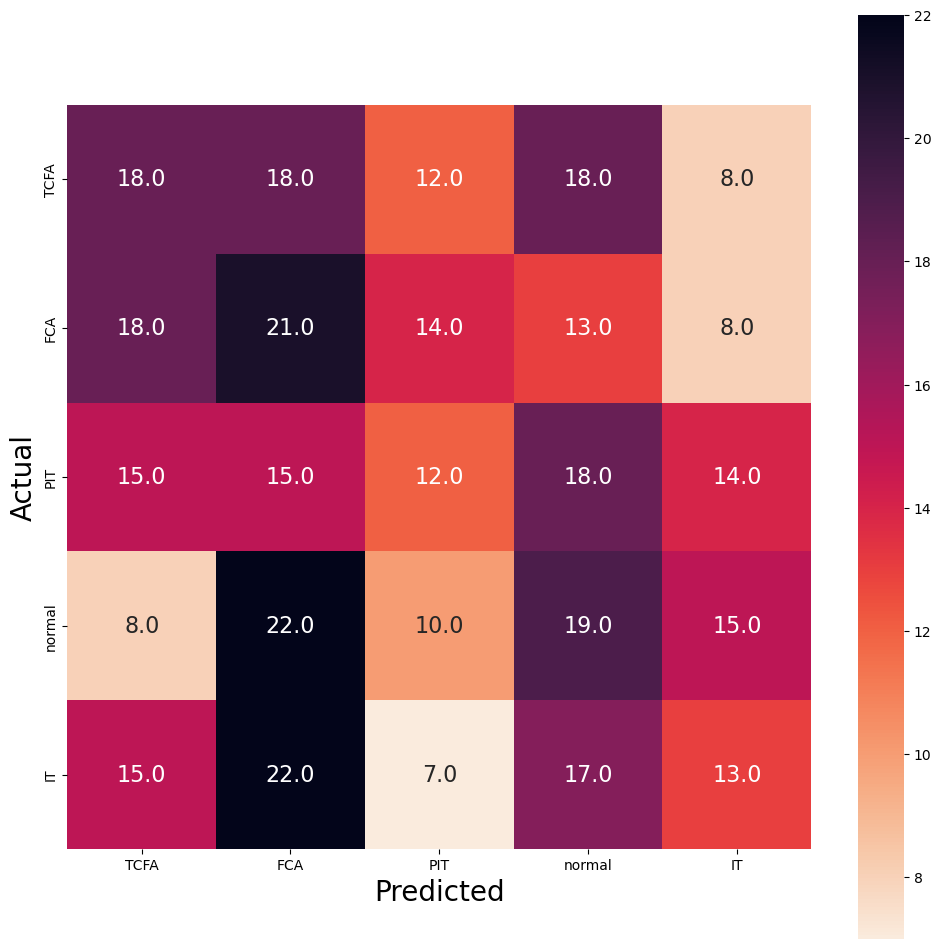

In [29]:


label = ['TCFA', 'FCA', 'PIT', 'normal', 'IT']
#Ypred = np.argmax(cnn_predictions, axis=1)
#Ytrue = np.argmax(test_set.labels, axis=0)

cm = confusion_matrix(test_set.labels, cnn_predictions_max)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()